In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.5 MB/s eta 0:00:00


In [ ]:
import os.path as osp

import torch
from sklearn.metrics import roc_auc_score, accuracy_score

import torch_geometric.transforms as T
from torch_geometric.datasets import KarateClub
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling

import networkx as nx
import matplotlib.pyplot as plt

# Link prediction for the Karate Club network

From: https://docs.dgl.ai/en/1.1.x/generated/dgl.data.KarateClubDataset.html

Zachary’s karate club is a social network of a university karate club, described in the paper “An Information Flow Model for Conflict and Fission in Small Groups” by Wayne W. Zachary. The network became a popular example of community structure in networks after its use by Michelle Girvan and Mark Newman in 2002. Official website: http://konect.cc/networks/ucidata-zachary/

Karate Club dataset statistics:
- Nodes: 34
- Edges: 156
- Number of Classes: 2

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available(): # "CUDA" version for MacOS
    device = torch.device('mps')
else:
    device = torch.device('cpu')

In [ ]:
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.2, num_test=0.1, is_undirected=True,
                      add_negative_train_samples=False),
])
dataset = KarateClub(transform=transform)

After applying the `RandomLinkSplit` transform, the data is transformed from a data object to a list of tuples (train_data, val_data, test_data), with each element representing the corresponding split.

See the description below the graph plots for more information about what it means to split the data into train, validation, and test sets in this particular context.

In [ ]:
# The split is performed *each time* the data is accessed.
train_data, val_data, test_data = dataset[0]

# Plotting the graph

Plots three subplots showing the train, validation and test splits. The edges are colored according to their split:
- edges in the **training set** are colored in $\color{gray}\text{gray}$,
- edges that are only in the validation set are colored in $\color{green}\text{green}$, and
- edges that are only in the test set are colored in $\color{red}\text{red}$.

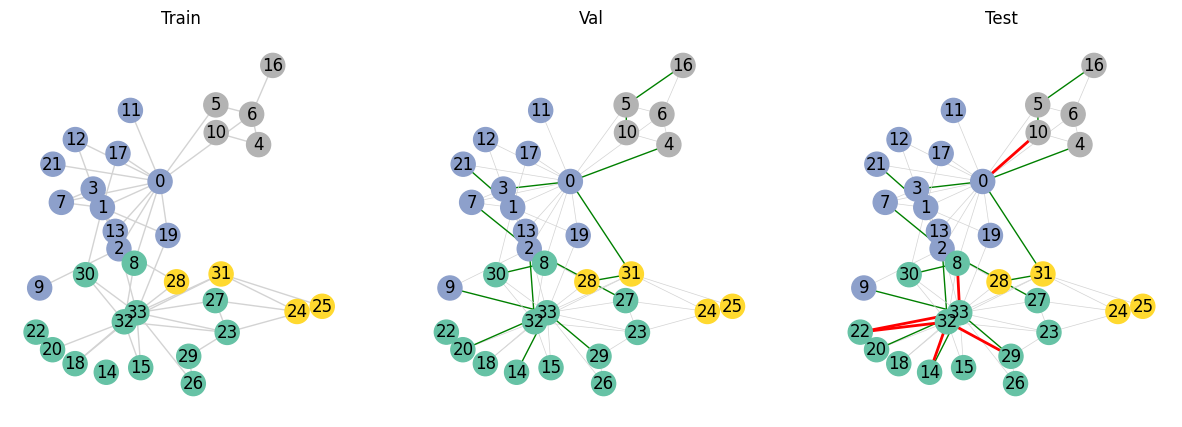

In [ ]:
def plot_subplots(train_data, val_data, test_data):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Test
    G = nx.Graph()
    G.add_nodes_from(range(train_data.num_nodes))

    G.add_edges_from(train_data.edge_label_index.t()[train_data.edge_label == 1].tolist(), color='lightgray', lw=0.5)
    G.add_edges_from(val_data.edge_label_index.t()[val_data.edge_label == 1].tolist(), color='green', lw=1)
    G.add_edges_from(test_data.edge_label_index.t()[test_data.edge_label == 1].tolist(), color='red', lw=2)
    pos = nx.spring_layout(G, seed=42)

    colors = [G[u][v].get('color') for u, v in G.edges]
    edge_widths = [G[u][v].get('lw') for u, v in G.edges]

    # pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color=train_data.y.cpu(), cmap="Set2", ax=axes[2], edge_color=colors, width=edge_widths)
    axes[2].set_title('Test')

    # Train
    G = nx.Graph()
    G.add_nodes_from(range(train_data.num_nodes))
    G.add_edges_from(train_data.edge_label_index.t()[train_data.edge_label == 1].tolist())

    nx.draw(G, pos, with_labels=True, node_color=train_data.y.cpu(), cmap="Set2", ax=axes[0], edge_color='lightgray', width=1)
    axes[0].set_title('Train')

    #  Validation
    G = nx.Graph()
    G.add_nodes_from(range(train_data.num_nodes))

    G.add_edges_from(train_data.edge_label_index.t()[train_data.edge_label == 1].tolist(), color='lightgray', lw=0.5)
    G.add_edges_from(val_data.edge_label_index.t()[val_data.edge_label == 1].tolist(), color='green', lw=1)

    colors = [G[u][v].get('color') for u, v in G.edges]
    edge_widths = [G[u][v].get('lw') for u, v in G.edges]

    # pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color=train_data.y.cpu(), cmap="Set2", ax=axes[1], edge_color=colors, width=edge_widths)
    axes[1].set_title('Val')

    plt.show()

plot_subplots(train_data, val_data, test_data)

# Explanation about the train/val/test splits

The task here is link prediction in a graph. The graph is split into train, validation and test sets, all nodes are shared in the three sets. The edges in the train set are the only ones used during training. Based on these edges, the model needs to learn to predict which edges are missing. Accordingly, the validation set contains all the edges in the train set, with a few ones that have been removed at the time of the split. The test set contains all edges in the original graph.

# Model

1. **Graph Convolutional Layers**:
   - **`conv1`**:
     - A `GCNConv` layer that maps input node features from `in_channels` to a hidden dimensional space (`hidden_channels`).
   - **`conv2`**:
     - A second `GCNConv` layer that refines the features, mapping them from `hidden_channels` to `out_channels`.


In [ ]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def predict(self, X, edge_label_index): # predicts a score for each edge in edge_label_index
        # It computes the dot product of the embeddings of the nodes at both ends of each edge
        z = self(X.x, X.edge_index)
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def predict_all(self, X, th=0.0):
        # Gives a score to all possible edges
        z = self(X.x, X.edge_index)
        prob_adj = z @ z.t()   # for each pair, computes the dot product of their embeddings
        return (prob_adj > th).nonzero().t()

# Training

To train the model, we need to provide it with positive (real) and negative (fake) edges. The graph contains only positive edges, so we need to sample negative edges from those missing in the graph. We can do this by using the `torch_geometric.utils.negative_sampling` function.

In [ ]:
def train_step(train_data, model, optimizer, criterion):
    model.train()
    optimizer.zero_grad()

    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method="sparse"
    )

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1
    )

    edge_labels = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.predict(train_data, edge_label_index)
    loss = criterion(out, edge_labels)
    loss.backward()
    optimizer.step()

    return loss

The test function also needs to sample negative edges, but then it computes the area under the ROC curve (AUC) and the accuracy scores evaluated on the provided dataset.

The AUC is a good metric for this task because it measures the model's ability to score appropriately the examples: i.e., it does not require to set a threshold to decide if an edge is positive or negative.

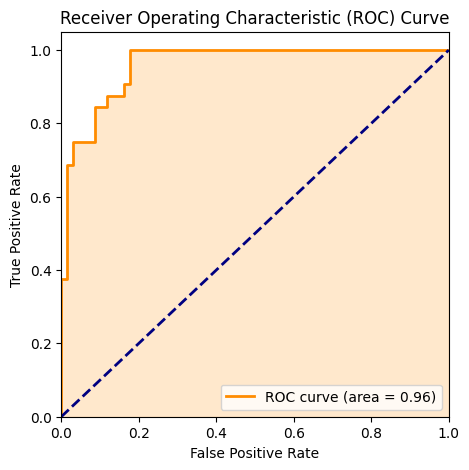

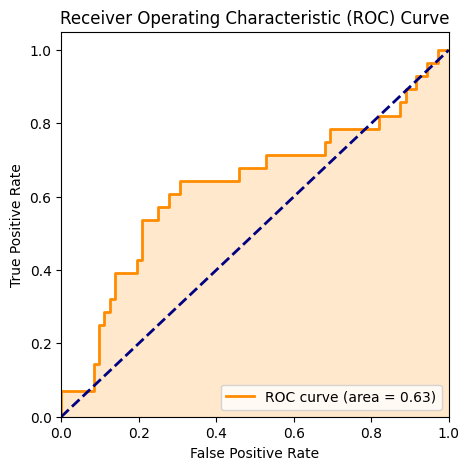

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# generate a plot to explain what the AUC curve is
def plot_auc_curve(randomness_level=10.0):
    # Generate some sample data
    x = np.random.rand(100)
    y_true = x**2 > 0.5
    y_scores = (x + np.random.rand(100)*randomness_level) ** 2

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.fill_between(fpr, tpr, alpha=0.2, color='darkorange')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax.legend(loc="lower right")
    plt.show()

plot_auc_curve(0.5)
plot_auc_curve(10)

In [ ]:
@torch.no_grad()
def test(model, data):
    model.eval()

    neg_edges_index = negative_sampling(
        edge_index=data.edge_index, num_nodes=data.num_nodes,
        num_neg_samples=data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [data.edge_label_index, neg_edges_index],
        dim=-1,
    )

    edge_label = torch.cat([
        data.edge_label,
        data.edge_label.new_zeros(neg_edges_index.size(1))
    ], dim=0)

    pred = model.predict(data, edge_label_index)
    pred = pred.sigmoid()
    return roc_auc_score(edge_label.cpu(), pred.cpu()), accuracy_score(edge_label.cpu(), pred.cpu() > 0.5)

# Model definition and training

In [ ]:
model = Net(dataset.num_features, 32, 16).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
losses = []
train_aucs, val_aucs, test_aucs = [], [], []
train_accs, val_accs, test_accs = [], [], []

for epoch in range(1, 300):
    loss = train_step(train_data, model, optimizer, criterion)
    train_auc, train_acc = test(model, train_data)
    val_auc, val_acc = test(model, val_data)
    test_auc, test_acc = test(model, test_data)
    losses.append(loss.item())

    train_aucs.append(train_auc)
    val_aucs.append(val_auc.item())
    test_aucs.append(test_auc.item())

    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

Epoch: 001, Loss: 0.6882, Val: 0.6933, Test: 0.7823
Epoch: 002, Loss: 0.6810, Val: 0.6763, Test: 0.7619
Epoch: 003, Loss: 0.6738, Val: 0.7733, Test: 0.7143
Epoch: 004, Loss: 0.6635, Val: 0.6600, Test: 0.6735
Epoch: 005, Loss: 0.6524, Val: 0.7296, Test: 0.5612
Epoch: 006, Loss: 0.6391, Val: 0.7659, Test: 0.6531
Epoch: 007, Loss: 0.6197, Val: 0.7548, Test: 0.6122
Epoch: 008, Loss: 0.6414, Val: 0.7541, Test: 0.5170
Epoch: 009, Loss: 0.6084, Val: 0.6978, Test: 0.5340
Epoch: 010, Loss: 0.5978, Val: 0.6844, Test: 0.5918
Epoch: 011, Loss: 0.5686, Val: 0.6948, Test: 0.5510
Epoch: 012, Loss: 0.5391, Val: 0.6370, Test: 0.6259
Epoch: 013, Loss: 0.5173, Val: 0.6437, Test: 0.6190
Epoch: 014, Loss: 0.5014, Val: 0.6341, Test: 0.6667
Epoch: 015, Loss: 0.5089, Val: 0.6533, Test: 0.6803
Epoch: 016, Loss: 0.4447, Val: 0.6289, Test: 0.7449
Epoch: 017, Loss: 0.4921, Val: 0.6630, Test: 0.7619
Epoch: 018, Loss: 0.4325, Val: 0.6215, Test: 0.7279
Epoch: 019, Loss: 0.4178, Val: 0.6570, Test: 0.6122
Epoch: 020, 

## Plotting moving averages for of the loss

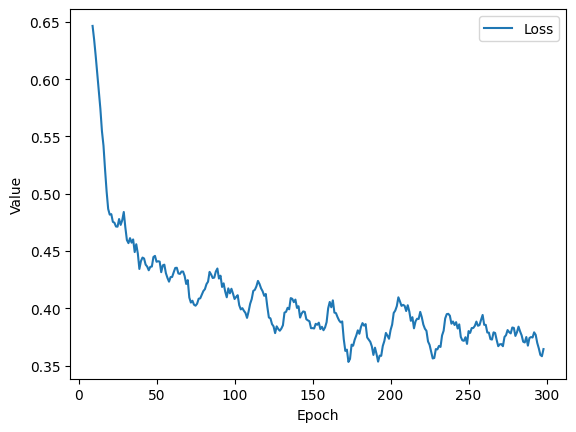

In [ ]:
import pandas as pd

losses_ma = pd.Series(losses).rolling(window=10).mean()
train_aucs_ma = pd.Series(train_aucs).rolling(window=10).mean()
val_aucs_ma = pd.Series(val_aucs).rolling(window=10).mean()
test_aucs_ma = pd.Series(test_aucs).rolling(window=10).mean()
train_accs_ma = pd.Series(train_accs).rolling(window=10).mean()
val_accs_ma = pd.Series(val_accs).rolling(window=10).mean()
test_accs_ma = pd.Series(test_accs).rolling(window=10).mean()

plt.plot(losses_ma, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()

## Plotting moving averages for the AUC

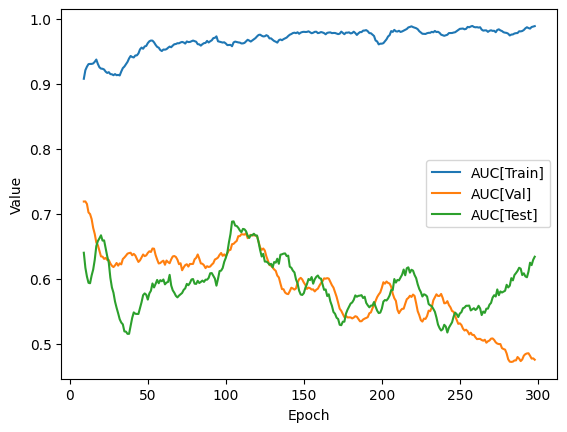

In [ ]:
plt.plot(train_aucs_ma, label='AUC[Train]')
plt.plot(val_aucs_ma, label='AUC[Val]')
plt.plot(test_aucs_ma, label='AUC[Test]')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()

## Plotting moving averages for the accuracy

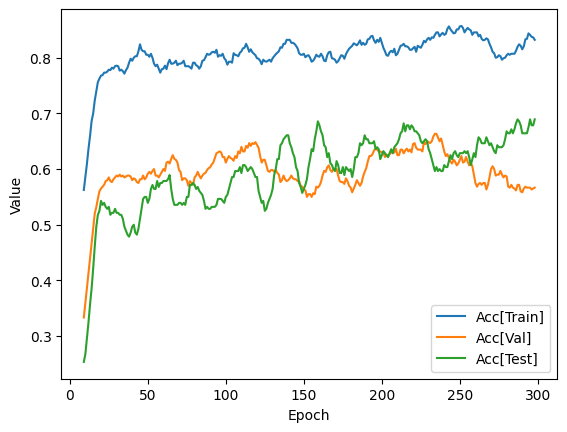

In [ ]:
plt.plot(train_accs_ma, label='Acc[Train]')
plt.plot(val_accs_ma, label='Acc[Val]')
plt.plot(test_accs_ma, label='Acc[Test]')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()